# Importing your own catalogs into HiPSCat format
To accomplish this we will utilize the `hipscat-import` [library](https://github.com/astronomy-commons/hipscat-import/tree/ADASS-Tutorial).

In [1]:
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.pipeline import pipeline_with_client
from hipscat.io import write_metadata
from dask.distributed import Client

import os
from pathlib import Path

In [2]:
#small function to gather the parquet metadata of our sample data
# NOTE: this function can only be run on a dataset that is already
#       in the parquet file format

def write_parquet_metadata(cache_dir):
    metadata_file = os.path.join(cache_dir, "_metadata")
    if not os.path.exists(metadata_file):
        write_metadata.write_parquet_metadata(cache_dir)
    return metadata_file

This library uses its `ImportArguments` class to set-up the import runner with the inital variables
* `output_catalog_name`: name of the output HiPSCat
* `input_path`: directory location of the list of initial catalog files
* `input_format`: input format of the catalog files, currently accepts [`parquet`, `csv`, `csv.gz`, `fits`]
* `ra_column` : Right Ascension column name in the initial catalog
* `dec_column` : Declination column name in the initial catalog
* `id_column` : Unique ID column for each entry in the initial catalog
* `output_path` : directory location of the output HiPSCat
* `dask_tmp` : directory location for dask to write scratch files, and hipscat-import to write intermediate step files
* `use_schema_file` : directory location for a parquet metadata file for the catalog
* `manual_dtype` : python dictionary of {column_name: dtype} to overwrite the inferred dtype
* `pixel_threshold` : the maximum number of rows to be in each hipscat pixel directory
* `overwrite` : will overwrite in hipscat file in the specified `output_path`

Once these variables have been initialized, we can call the import runner function to start the import.

The import has 5 main phases:
1. **Mapping**: initial read and gathering of catalog statistics. 
2. **Binning**: creating the hipscat partitioning scheme
3. **Splitting**: second read and partitioning of rows into the hipscat scheme
4. **Reducing**: map reduce stage to create final HiPSCat format
5. **Finishing**: output of metadata files and MOC maps

Below is an example to import a subset of the gaia dr3 catalog into HiPSCat, takes about 5 minutes.

In [3]:
source_directory = f"{Path.home()}/shared/lincc-frameworks/data/ADASS_Tutorial/gaia_exA/cache"
output_path = f"{Path.home()}/ADASS_LSDB_tutorial/nb/hipscats"
if not os.path.exists(output_path):
    os.makedirs(output_path)
args = ImportArguments(
    output_catalog_name="gaia_exA",
    input_path=source_directory,
    input_format="parquet",
    ra_column="ra",
    dec_column="dec",
    id_column="source_id",
    output_path=f"{Path.home()}/ADASS_LSDB_tutorial/nb/hipscats",
    dask_tmp=f"{Path.home()}/ADASS_LSDB_tutorial/nb/hipscats", 
    use_schema_file=write_parquet_metadata(source_directory),
    manual_dtypes={'libname_gspphot':'unicode'},
    pixel_threshold=500_000,
    highest_healpix_order=5,
    overwrite=True
)

Planning  : 100%|██████████| 5/5 [00:00<00:00, 152.48it/s]


In [4]:
%%time
with Client( #instantiate a dask.distributed client
    local_directory=args.dask_tmp,
    n_workers=4
) as client:
    pipeline_with_client(args, client)

Finishing : 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


CPU times: user 8.61 s, sys: 2.05 s, total: 10.7 s
Wall time: 2min 30s


In [5]:
import lsdb

#reading from local disk

gaia = lsdb.read_hipscat(args.output_path+"/gaia_exA")
gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Dir,Npix
npartitions=23,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,bool,bool,int64,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

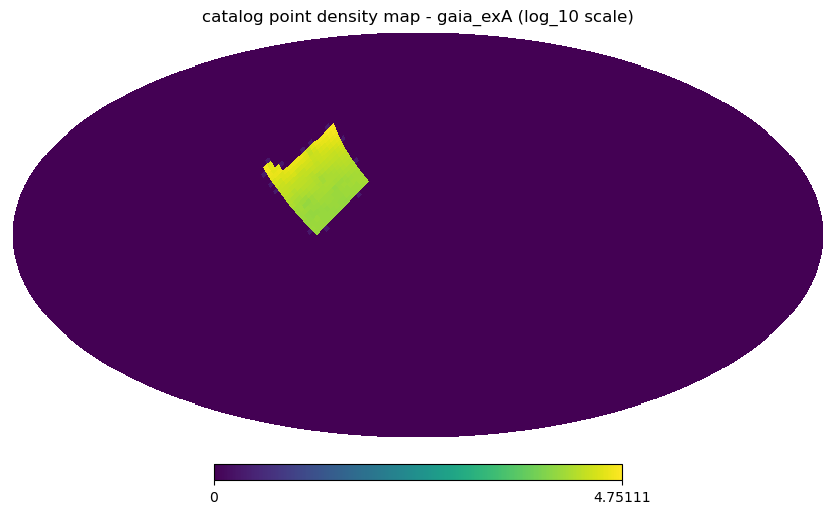

In [6]:
from hipscat.inspection import plot_points
plot_points(gaia.hc_structure)